***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Tech Intro Vorlesung 8 (Syntaxregeln komplexer Sätze und Verbalkomplex)

In [1]:
import nltk

In [2]:
from nltk.parse.stanford import StanfordParser, StanfordDependencyParser
import os

PATH_TO_CORE = os.getenv("HOME") + os.sep + os.path.join("nltk_data", "stanford-corenlp-full-2018-10-05")
PATH_TO_GER_MODEL = os.getenv("HOME") + os.sep + os.path.join("nltk_data", "stanford-models-2018-10-05")

jar = os.path.join(PATH_TO_CORE, "stanford-corenlp-3.9.2.jar")
model = os.path.join(PATH_TO_CORE,"stanford-corenlp-3.9.2-models.jar")
ger_model = os.path.join(PATH_TO_GER_MODEL, "stanford-german-corenlp-2018-10-05-models.jar")

stanford_parser = StanfordParser(jar, model, model_path="edu/stanford/nlp/models/lexparser/" + "englishPCFG.ser.gz")
stanford_ger_parser = StanfordParser(jar, ger_model, model_path="edu/stanford/nlp/models/lexparser/" + "germanPCFG.ser.gz")

stanford_dep_parser = StanfordDependencyParser(jar, model, model_path="edu/stanford/nlp/models/lexparser/" + "englishPCFG.ser.gz")
stanford_ger_dep_parser = StanfordDependencyParser(jar, ger_model, model_path="edu/stanford/nlp/models/lexparser/" + "germanPCFG.ser.gz")

In [3]:
import spacy
from spacy import displacy
nlp = spacy.load('de_core_news_sm')

In [4]:
from nltk import DependencyGraph
from nltk.tree import Tree
from itertools import chain


### tree_labeled-Methode für DependencyGraphs (pretty_print-Dependenzbäume mit Labels):
def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

    
DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled

In [5]:
#Konvertierungsfunktion von conll(4)-Format (MALT-tabular) für Rendering mit displaCy:
def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex

#html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

In [6]:
# MANUELLES DEP-INPUT für displaCy: s. https://spacy.io/usage/visualizers/#manual-usage

ex = {
    "words": [
        {"text": "Das", "tag": "DT"},
        {"text": "ist", "tag": "VBZ"},
        {"text": "ein", "tag": "DT"},
        {"text": "Satz", "tag": "NN"}
    ],
    "arcs": [
        {"start": 0, "end": 1, "label": "sb", "dir": "left"},
        {"start": 2, "end": 3, "label": "nk", "dir": "left"},
        {"start": 1, "end": 3, "label": "pd", "dir": "right"}
    ]
}

html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

---

# Verwendungsbeispiele

In [7]:
sent = """Das _ 2 sb  
ist _ 0 ROOT
ein _ 4 nk
Satz _ 2 pd
"""

dg = DependencyGraph(sent)

#Konvertierung in einen gelabelten Dependenzbaum (tree_labeled):
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

#mit Verwendung Konvertierungsfunktion (aus MALT/CONLL4-FORMAT in DISPLACY-DEP-INPUT):
ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        ist(ROOT)         
   ┌────────┴────────┐     
   │              Satz(pd)
   │                 │     
Das(sb)           ein(nk) 



In [8]:
## Analyse in UD-Format ('primacy of content words'; Kopula als Dependent COP):

In [9]:
sent = """Das _ 4 nsubj  
ist _ 4 cop
ein _ 4 det
Satz _ 0 ROOT
"""

dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           Satz(ROOT)         
    ┌──────────┼─────────┐     
Das(nsubj)  ist(cop)  ein(det)



---

--- 

# Parser-Tests

### Parsing-Test `Stanford-Parser` (`englishPCFG`: Penn-Treebank-PSG-Struktur + UD-Dependenzen):

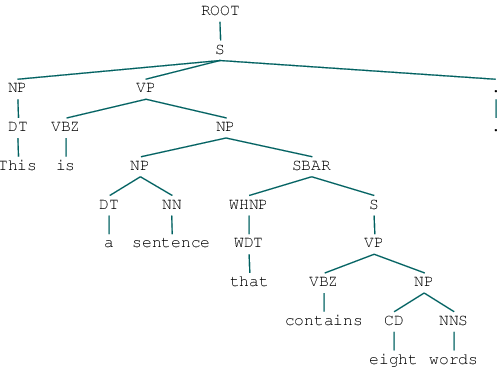

ROOT -> S
S -> NP VP .
NP -> DT
DT -> 'This'
VP -> VBZ NP
VBZ -> 'is'
NP -> NP SBAR
NP -> DT NN
DT -> 'a'
NN -> 'sentence'
SBAR -> WHNP S
WHNP -> WDT
WDT -> 'that'
S -> VP
VP -> VBZ NP
VBZ -> 'contains'
NP -> CD NNS
CD -> 'eight'
NNS -> 'words'
. -> '.'

____________________________________________________________

                    sentence(root)                                        
     ┌─────────┬──────────┼──────────────────────────┐                     
     │         │          │                    contains(acl:              
     │         │          │                        relcl)                 
     │         │          │             ┌────────────┴─────────────┐       
     │         │          │             │                     words(dobj) 
     │         │          │             │                          │       
This(nsubj) is(cop)     a(det)     that(nsubj)               eight(nummod)



This	DT	4	nsubj
is	VBZ	4	cop
a	DT	4	det
sentence	NN	0	root
that	WDT	6	nsubj
contains	VBZ	4	acl:relcl
eight	CD	8	nummod
words	NNS	6	dobj



In [10]:
sentence = "This is a sentence that contains eight words."

#CFG-Parsing:
tree = list(stanford_parser.raw_parse(sentence))[0]
display(tree)
#tree.pretty_print(unicodelines=True)

for x in tree.productions(): print(str(x))

print("\n____________________________________________________________\n")    
    
#Dependency-Parsing:
dg = list(stanford_dep_parser.raw_parse(sentence))[0]
#display(dg)
dg.tree_labeled().pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

print(dg.to_conll(4))

### Parsing-Test `spaCy`: nur Dependency-Parsing (`de_core_news_sm` = TIGER-Dependenzen):


In [11]:
sentence = "Das ist ein Satz, der acht Wörter enthält."

#Dependency-Parsing:
sent = nlp(sentence)

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})        

Das	der	PRON	PDS	sb	Xxx	True	True
ist	sein	AUX	VAFIN	ROOT	xxx	True	True
ein	einen	DET	ART	nk	xxx	True	True
Satz	Satz	NOUN	NN	pd	Xxxx	True	False
,	,	PUNCT	$,	punct	,	False	False
der	der	PRON	PRELS	sb	xxx	True	True
acht	acht	NUM	CARD	nk	xxxx	True	True
Wörter	Wort	NOUN	NN	oa	Xxxxx	True	False
enthält	enthalten	VERB	VVFIN	rc	xxxx	True	False
.	.	PUNCT	$.	punct	.	False	False
